# Solar House Optimization
#### PDO SP21 Final Project Report
#### Naomi Chiu
---

## I. Executive Summary
For my optimization problem, I chose to explore solar house designs for building a greenhouse around a house. I was specifically interested in optimizing to reduce the inner temperature fluctuations from a set desired temperature throughout the year based on the specific surface area to volume ratio of the greenhouse. My model was built off thermodynamic calculations based on the dimensions of the greenhouse and random distributions created from weather data (solar radiation and air temperature). To get an accurate view of the year-round performance, my optimization problem was structured as a multi-objective optimization between the summer and winter performance, as these are the two extreme conditions that the solar house would be exposed to. I ran my optimization as a Monte Carlo simulation with multiple restarts and performed uncertainty propegation to verify my results. My model results were not very accurate due to simplifications and assumptions that I made that ignored the transient energy transfer over the course of the day, instead modeling it as a constant. However, my model was able to illustrate some key relationships and provide numerical evidence for some intuitive assumptions such as lower SA/V ratios have less temperature fluctuations and that overall performance is better in moderate climates with less extreme temperature ranges. 

## II. Background
In terms of sustainable living, one of the most common ways that people try to reduce their energy consumption is by utilizing the energy from the sun. Solar homes are a general category of houses with modifications that harness energy from the sun to put towards everyday usages. I wanted to look at a house with a greenhouse built around it. Inspired by one such house in [Stockholm](https://www.youtube.com/watch?v=30ghnDOFbNQ), this type of solar home aids in the thermoregulation of the house by creating an insulative layer around the house that is heated with energy from solar radiation. This decreases the amount of energy needed to heat and cool the house itself, saving homeowners money in the long run. The stakeholders in this project are people who may be interested in building a greenhouse around their home. There are many different factors that affect the performance of such a structure and the results of this optimization can help them estimate the performance based on their climate and weather conditions. The results can also help guide their designs by providing them with insights of how they can tune their structure to meet the demands of their environment. Stakeholders need relevant information to help them decide if this is a feasible option for their own home and rough generalizations to help them estimate the associated costs. 

## III. Formulation
For my optimization problem, I decided that the most useful insight that I could generate was an ideal surface area to volume ratio. I didn't want to run my optimization on specific configurations as that would limit the effectiveness of results. By presenting my optimization as a function of a generalized ratio, stakeholders could customize their designs to match the ideal ratio, rather than finding a specific dimension combination that was most similar to their house. 

For results, I chose to optimize for minimal temperature fluctuations throughout the year. In any living condition, people set their thermostats to a desired temperature and conceptually, a greenhouse built around their house should work to help them maintain that desired temperature. As such, I believed that the optimization goal that made the most sense was to try to find a design that would minimize how much the actual temperature deviated from the set temperature no matter the time of year (since there would be positive temperature deviation in the warmer months and a negative deviaition during the colder months). 

This optimization problem was unconstrained as my application was intended to be more of a research/learning tool. I chose not to cut off scenarios that would result in failure as these failure cases are needed as necessary feedback for designs to understand what not to do. However, since no solar home needs to be designed for all climates, I did put limits on the input parameters so that the optmization problem would report back for specific environment conditions. These limits were taken from location-specific data that I found to reflect realistic values. I started with optimizing for a solar house built in the Boston area (since that's where Olin is). For weather data, I included the daytime radiative heat flux and daytime and nighttime temperatures for the hottest time of the year (around July) and the coldest time of the year (around January). I only considered the extreme cases as other time of the year would fall somewhere between the two extremes. My data was taken from [here](https://weatherspark.com/y/26197/Average-Weather-in-Boston-Massachusetts-United-States-Year-Round#:~:text=In%20Boston%2C%20the%20summers%20are,or%20above%2091%C2%B0F) and I created normal distributions for each based on the 10-90th percentile bands on the various charts that were used to capture the uncertainty of weather conditions in my model.

My formal optimization problem can be written as: 
$$ \min\, \Delta T$$
$$ \text{wrt.}\, SA/V_{ratio}$$
$$ 0.56 \frac{1}{\text{m}} < SA/V_{ratio} \leq 0.66 \frac{1}{\text{m}}$$
$$ 4.5 \text{ kWh} \leq \dot{q}_{summer-rad} \leq 8.5 \text{ kWh} $$
$$ 0.5 \text{ kWh} \leq \dot{q}_{winter-rad} \leq 2.5 \text{ kWh} $$
$$ 21 ^\circ\text{C} \leq T_{out-SummerDay} \leq 31 ^\circ\text{C} $$
$$ 15 ^\circ\text{C} \leq T_{out-SummerNight} \leq 21 ^\circ\text{C} $$
$$ -1 ^\circ\text{C} \leq T_{out-WinterDay} \leq 10 ^\circ\text{C} $$
$$ -12 ^\circ\text{C} \leq T_{out-WinterNight} \leq 2 ^\circ\text{C} $$

As the input to my problem was the ratio between the surface are and the volume of the greenhouse, I needed to create a way to generate real dimensions for my later calculations. To make things easier, I chose to model all of the greenhouses as rectangular prisms 25 feet tall (7.62 meters) with a square cross section (length and width are equal). The surface area included the 4 vertical walls as well as the square roof, calculated as
$$ SA = 4(7.62 \text{ m}*L)+L^2 $$
where $L$ is the length of a side. The volume was easily calculated as
$$ V = 7.62 \text{ m}*L^2 $$
With these equations for the surface area and volume, I was able to algebraically solve for the side length from the surface are-volume ratio as
$$ L = \frac{30.48 \text{ m}}{7.62 \text{ m}*SA/V_{ratio}-1} $$

With this formulation of finding the side length from the $SA/V_{ratio}$, I had to implement limits on the ratio. The upper bound limit was needed to ensure that the side length would be positive and non-zero. The lower bound limit was simply to prevent the greenhouse from exceeding realistic sizes, capping the maximum side length at 30 meters. Once the surface area and volume were calculated, I used the values to calculate the heat transfer through the greenhouse. I divided the heat transfer of a single greenhouse into 4 separate calculations for summer daytime, summer nighttime, winter daytime, and winter nighttime. For each of these 4 cases, the change in energy over time was calculated as
$$ \frac{dU}{dt} = \dot{q}_{rad}*SA_{sun} - \frac{T_{in}-T_{out}}{\frac{Wall_{thickness}}{k*SA}} $$

where $T_{in}$ was the desired temperature of the inside of the greenhouse which I set as 65$^\circ F$ and $T_{out}$ is the outside temperature. This equation accounts for the energy gained from the radiation in through one of the vertical walls ($SA_{sun}$) as well as the flow of energy through the walls and roof of the greenhouse due to conduction. This calculation was then multiplied by the number of hours for that time of day (longer daytime and shorter nighttime in the summer and vice versa in the winter) to calculate the net change in energy. These energy differences were then converted into the change in the internal temperature based on the thermal mass inside of the greenhouse. For simplicity's sake, I chose to model the thermal mass as 50% of the internal volume as air, 25% of the internal volume as wood and 25% of the internal volume as brick to estimate the volumetric composition with a house inside the greenhouse. The temperature change was calculated as
$$ \Delta T =  \frac{dU*t}{(V_{air}*\rho_{air}*{C_p}_{air})+(V_{wood}*\rho_{wood}*{C_p}_{wood})+(V_{brick}*\rho_{brick}*{C_p}_{brick})} $$

Once I had the total change in temperature based on the change in energy within the greenhouse, I summed the nighttime and daytime temperature changes to find the total temperature change over the course of a day. The total temperature change that I used in my optimization was a multi-objective function that combined the daily temperature change in the summer and the winter. I solved this optimization using a Monte Carlo method and calibrated uncertainty propegation. My model had an independence copula as none of the weather parameters were reliant on any of the others in any concrete manner due to the inconsistency of weather patterns and possibility for drastic changes over the course of a day.

This model is limited in that it does not take into account the change in energy transfer over time. For the energy conducted through the glass walls, the amount of energy transferred is dependent on the temperature difference between the inner surface of the glass and the outer surface of the glass. As I do not calculate the intermediate changes in temperature over the course of the day, I assume that there is a constate rate of energy transfer by conduction. This likely indicates that my results will be an overestimation of the actual conditions, making my results a poor method of evaluating exact performance but acceptable for understanding relative performance to other greenhouse configurations. I think that this limiatation is acceptable as it is intended to be a resource/learning tool to help stakeholders begin to understand what parameters they need to consider for their design. In addition, all of the greenhouses were made to be square when in reality, the performance of a greenhouse can easily be altered by changing the area of the sun facing wall to increase/decrease the energy from solar radiation accordingly. 

## IV. Results
Unfortunately my results were not very interesting. Due to the limits of my model and the overestimation of the temperature changes over the course of the day, the temperature changes are so drastic that the only way to minimize the changes are by increasing the thermal mass of the house within. As a result, the optimal result for my model was always the minimal possible surface area to volume ratio of 0.56, even with varying weather conditions and multiple restarts. While this wasn't super interesting to look at, it was something that I had expected given how I set up my model. Below are two sinew plots that show the relationship between the SA/V Ratio and the change in temperature, one for the summer and one for the winter. Both of the plot support my optimization conclusion that a small SA/V Ratio is best.

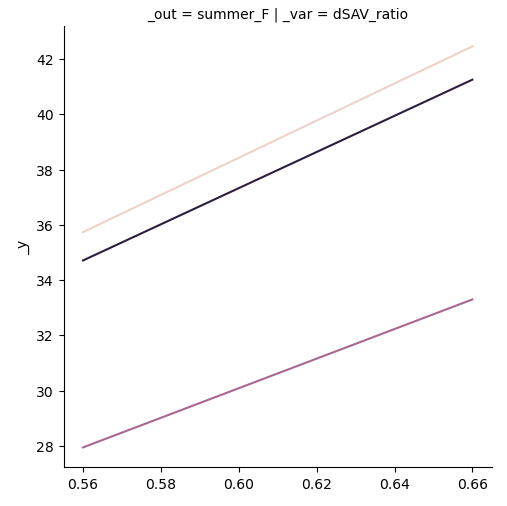
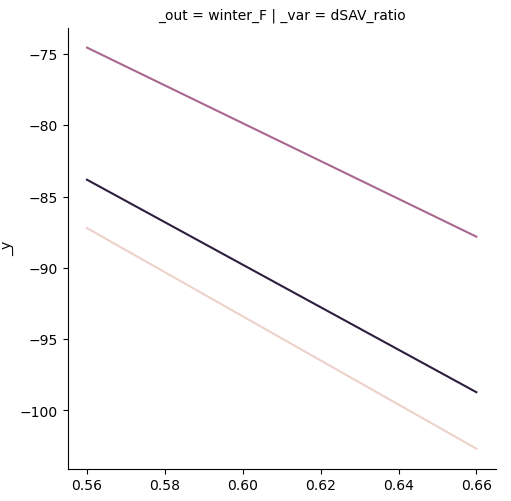

However, by looking at the different relationships and behavior of the greenhouse under different conditions, I was able to identify trends that might be helpful for defining designs. I first started off by looking at the distribution of performance when the winter and summer temperature changes were separated. I created a pareto frontier that showed the results that minimized both the summer and winter $\Delta$T's.

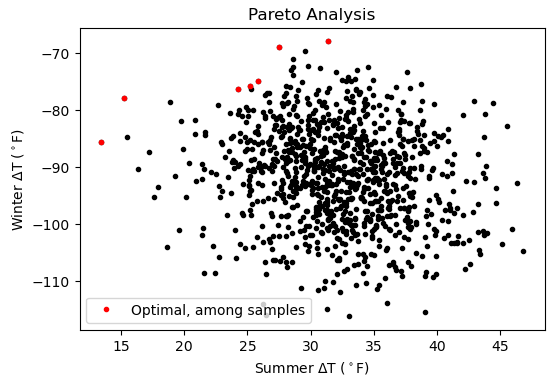

Looking at the shape of the pareto frontier, it made a lot of sense that there was a tradeoff between the summer and winter performance as the energy is conducted through the walls in different directions between the two times of the year. Knowing this tradeoff, the feasiblity of building such a solar home in the Boston area is nearly impossible as the difference between the summer temperatures and the winter temperatures is too severe for a single design to optimize for. Additional features that I didn't model could be incorporated to create a feasible design, by adjusting the structure throughout the seasons. Including windows that could be opened during the summer to vent out heat could decrease the summer temperature changes while removable covers could increase the insulation of the greenhouse during the winter. Below, I also created an uncertainty propegation model to check this conclusion. The plot supports my conclusion as the there is a significant gap between the summer mean and winter mean. In addition, as the winter temperatures had larger ranges in the weather data, the performance is also significantly more variable than in the summer.

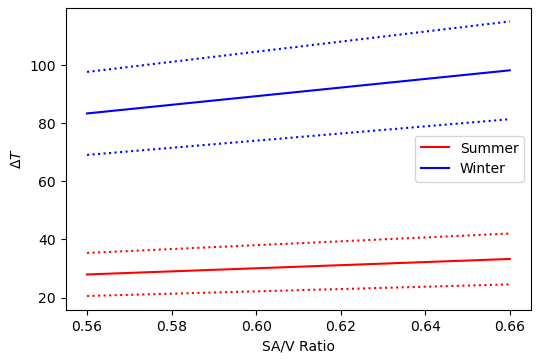

With these results, I was curious how a greenhouse would perform in a more moderate climate. I repeated my modeling process using data from [Santa Cruz, California](https://weatherspark.com/y/482/Average-Weather-in-Santa-Cruz-California-United-States-Year-Round). Below are the bounds that I used to create normal distributions for the weather data. 
$$ 7.5 \text{ kWh} \leq \dot{q}_{summer-rad} \leq 9 \text{ kWh} $$
$$ 1 \text{ kWh} \leq \dot{q}_{winter-rad} \leq 3 \text{ kWh} $$
$$ 18 ^\circ\text{C} \leq T_{out-SummerDay} \leq 24 ^\circ\text{C} $$
$$ 13 ^\circ\text{C} \leq T_{out-SummerNight} \leq 16 ^\circ\text{C} $$
$$ 13 ^\circ\text{C} \leq T_{out-WinterDay} \leq 18 ^\circ\text{C} $$
$$ 4 ^\circ\text{C} \leq T_{out-WinterNight} \leq 13 ^\circ\text{C} $$

The optimization result was the same as the Boston case, with the smallest possible SA/V Ratio of 0.56. The sinew plots also supported the conclusions from the Boston model.

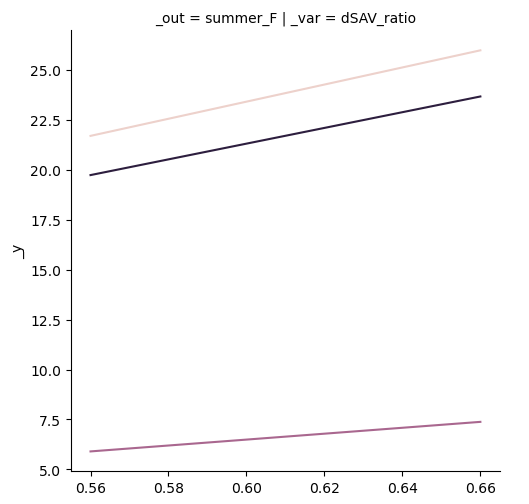
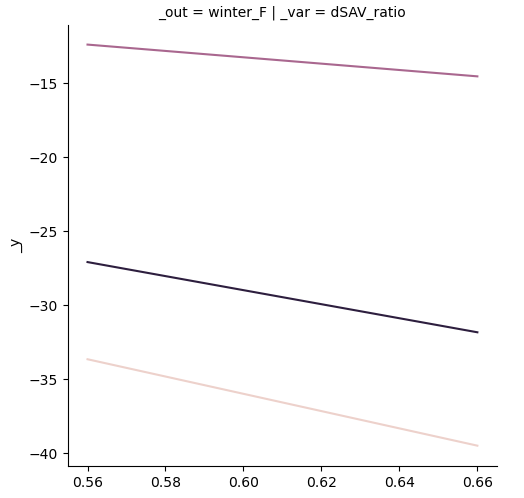

Looking at the pareto frontier of the California conditions, a similar trade off can be seen. However, the magnitude of the temperature change is significantly smaller and more reasonable. This makes sense as the California climate has smaller variances from the desired 65$^\circ F$ so the energy transfer due to conduction through the walls is less drastic. 

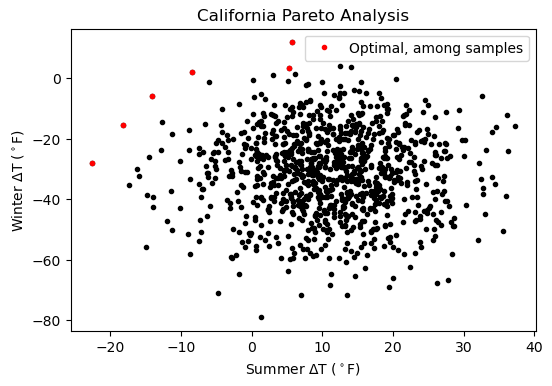

The uncertainty propegation model also showed that with a more temperate climate and less extreme weather conditions, it is more feasible to optimize for year-round performance without any extra adjustments.

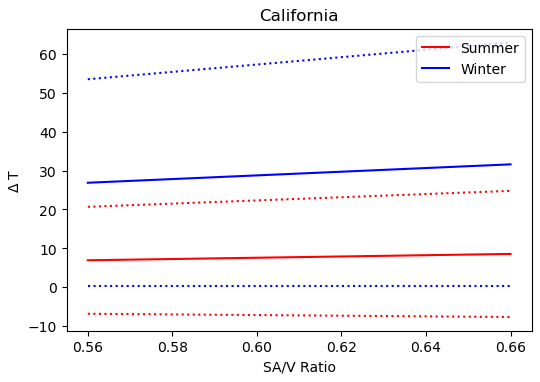

## V. Conclusion
Based on the results of my optimization, I would recommend solar houses of this type to be designed to minimze the SA/V ratio. Reducing this ratio decreases the surface area through which energy is conducted out as well as increasing in inside volume and thus the thermal mass of the system, altogether increasing the system's resistance to wild temperature fluctuations. However, the manner in which I chose to implement my model is highly inaccurate for performance predictions so I would strongly recommend that further analysis be done with proper modeling of the transient behavior of energy transfer. Additional attributes that could be helpful to inform designs would be exploring different size ratios of the greenhouse. In my model, they all had a square footprint, meaning only 1/4 of the perimeter surface area (not including the roof) is exposed to the sun. However, more rectangular configurations can increase the suface area exposed to the sun without changing the SA/V ratio which can help increase the energy that comes in during colder months. I also was not able to perform any material analyses, but experimenting with different materials or composite greenhouses (with more insulative, opaque materials along the walls that don't face the sun) could also increase the feasibility of designs. 